# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

First Authors: Alexandra Fink-Skular & Christina Maher  \
Updated: 08/30/2024 by AFS

In [14]:
# load required libraries
import numpy as np
import pandas as pd
from glob import glob
import datetime
from IPython import display
# import NeuroCluster


In [15]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# If you are running NeuroCluster from a local repo (not through a virtual environment package install)
user_base_dir   = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/neuro_cluster_proj/'
# user_base_dir   = '/Path/To/NeuroCluster/NeuroCluster/'
sample_data_dir = f'{user_base_dir}NeuroCluster/data/'
results_dir     = f'{user_base_dir}NeuroCluster/results/'

# Let's store the date so we can keep track of versions
date = datetime.date.today().strftime('%m%d%Y')

In [17]:
# load custom functions
import sys
sys.path.append(f'{user_base_dir}NeuroCluster/')
import NeuroCluster


In [18]:
with open(f'{user_base_dir}NeuroCluster/requirements.txt') as f:
    required = f.read().splitlines()

print(f'Required packages: {required}')
# conda create --name <env> --file <this file>'

Required packages: ['anyio==4.4.0', 'appnope==0.1.4', 'argon2-cffi==23.1.0', 'argon2-cffi-bindings==21.2.0', 'arrow==1.3.0', 'asttokens==2.4.1', 'async-lru==2.0.4', 'attrs==23.2.0', 'Babel==2.15.0', 'backcall==0.2.0', 'beautifulsoup4==4.12.3', 'bleach==6.1.0', 'certifi==2024.7.4', 'cffi==1.16.0', 'charset-normalizer==3.3.2', 'comm==0.2.2', 'contourpy==1.2.1', 'cycler==0.12.1', 'debugpy==1.8.2', 'decorator==5.1.1', 'defusedxml==0.7.1', 'entrypoints==0.4', 'exceptiongroup==1.2.2', 'executing==2.0.1', 'fastjsonschema==2.20.0', 'fonttools==4.53.1', 'fqdn==1.5.1', 'h11==0.14.0', 'httpcore==1.0.5', 'httpx==0.27.0', 'idna==3.7', 'intel-openmp==2023.2.0', 'ipykernel==6.21.0', 'ipython==8.12.3', 'ipython-genutils==0.2.0', 'ipywidgets==8.0.4', 'isoduration==20.11.0', 'jedi==0.19.1', 'Jinja2==3.1.4', 'joblib==1.2.0', 'json5==0.9.25', 'jsonpointer==3.0.0', 'jsonschema==4.23.0', 'jsonschema-specifications==2023.12.1', 'jupyter-events==0.10.0', 'jupyter-lsp==2.2.5', 'jupyter_client==7.4.4', 'jupyter

# Neurocluster Workflow

This notebook performs a nonparametric permutation-based cluster test on continuous behavioral predictors for one example electrode. The workflow is outlined schematically below.

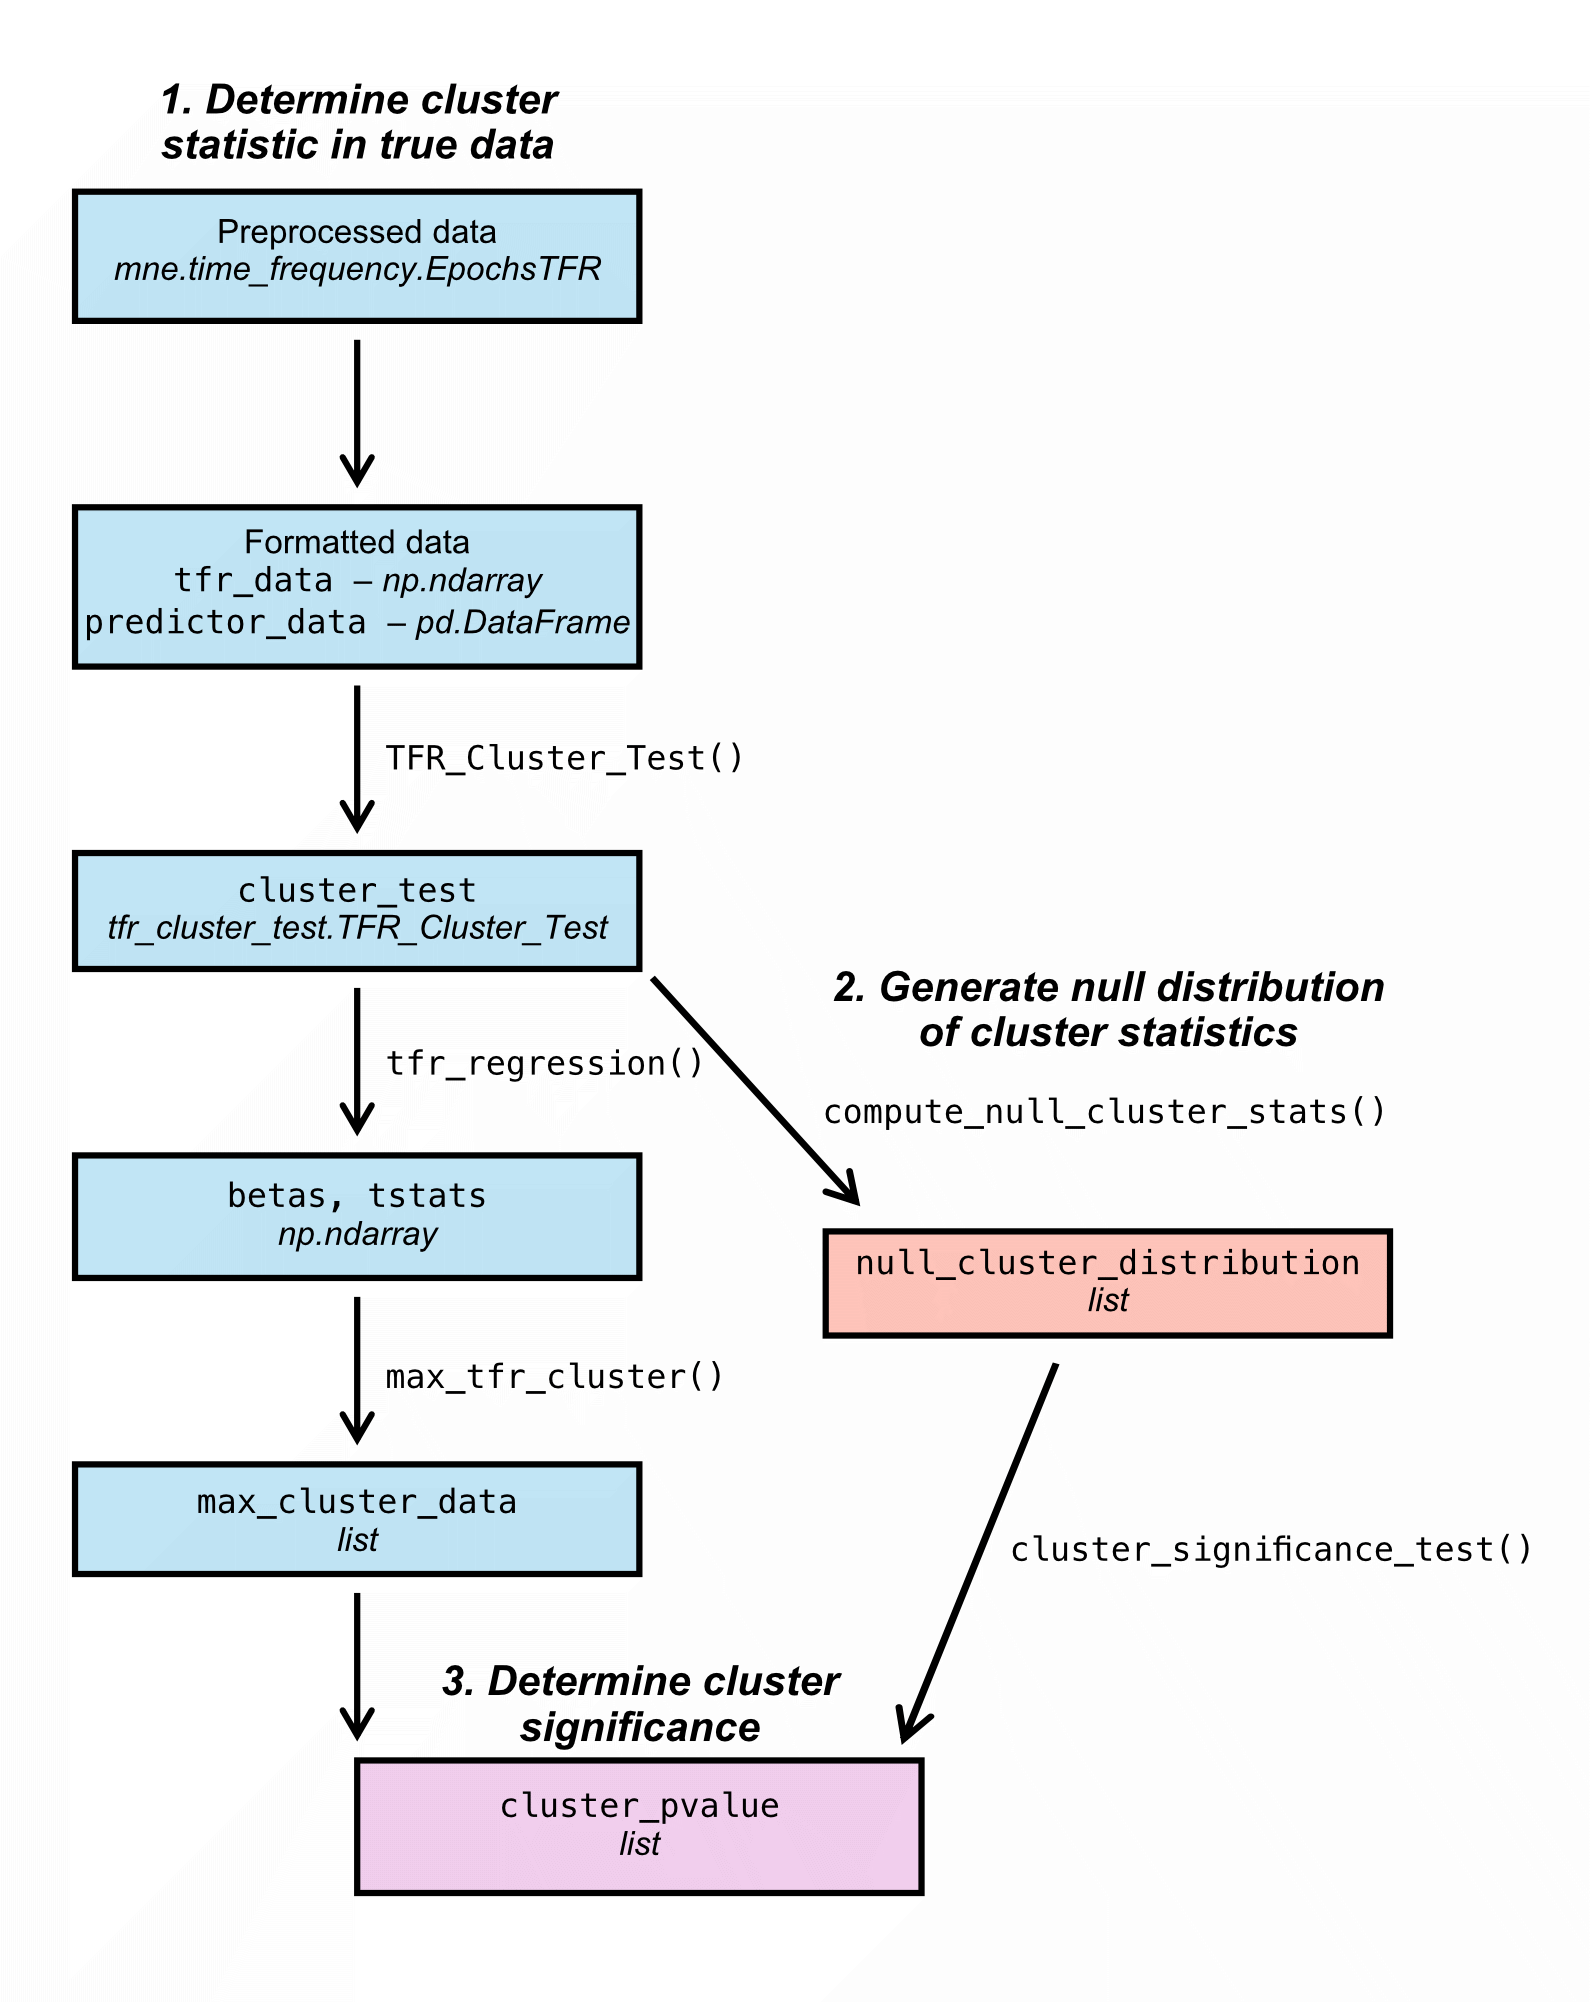

In [19]:
display.Image(f"{user_base_dir}/NeuroCluster/workflow/workflow.png",width=750)

# Step 1: Format input data (neural and behavioral)

The sample data for this notebook includes: 
- neural data: np.array (n_channels x n_trials x n_freqs x n_times)
- behavior data: pd.DataFrame (n_trials x n_variables)

These variables are extracted from an `mne.time_frequency.EpochsTFR` which is a spatiotemporal representation of neural data that includes power across trials, frequencies, and timepoints. Note, for this notebook we provide the neural and behavioral data in `np.array` *a priori*. These data can be found in the `sample_data_dir`.

Here is some example code, loading an `EpochsTFR` following preprocessing with  [MNE-Python](https://mne.tools/stable/index.html) and creating a neural data file (i.e., `channel_13.npy`) and our behavioral regressors (i.e., `sample_behavior.csv`):

`# load EpochsTFR data`


`power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}_tfr.h5')[0]`



`# save data from each channel to a .npy file`


`for i in range(len(power_epochs.info['ch_names'])):`

        channel = power_epochs.info['ch_names'][i]

        data = power_epochs.data[i]

        np.save(f'{results_dir}{channel}.npy', data)



`# save metadata as a numpy array to a .csv file`


`metadata = pd.DataFrame(power_epochs.metadata)`


`metadata.to_csv(f'{results_dir}sample_behavior.csv', index=False)`



In the following cell, let's load our template neural data into a dictionary and load the DataFrame of our behavioral predictors.

In [20]:
sample_ieeg_files = glob(f'{sample_data_dir}*.npy')
sample_ieeg_dict  = {f'{file.split("/")[-1].split(".")[0]}':np.load(file) for file in sample_ieeg_files}
ieeg_channels     = list(sample_ieeg_dict.keys())
sample_behav      = pd.read_csv(f'{sample_data_dir}sample_behavior.csv')

Let's define the behavioral variables we plan to include as independent variables in our linear regression (`multi_reg_vars`) and the regressor of interest (`target_var`) we will permute to determine whether significant clusters encoding this behavioral variable exist in our time x frequency data. All continuous predictors should be normalized. 

In [21]:
# set main predictor of interest for permutations *target_var must be a continuous numeric variable*
target_var = 'error'

# define subset of predictor variables from sample_behav to include in regression (should include target_var)
multi_reg_vars = ['outcome','error']

# subset input dataframe to include only multi_reg_vars
predictor_data = sample_behav.copy()[multi_reg_vars]

# let's print the first few rows of the predictor data to make sure it looks right
predictor_data.head()


,outcome,error
0,good,2.264982
1,bad,0.650167
2,bad,0.160829
3,good,-0.573178
4,good,0.552299


# Step 2: Perform within-electrode cluster test.

First, let's create a variable called `tfr_data` which is a `np.array` (dimensions should correspond with number of trials x number of frequencies x number of timepoints)

In [22]:
# subset demo channel data from sample_ieeg_dict and store as tfr_data variable: np.array of (num epochs x num frequencies x num times)
demo_channel = 'channel_4'
tfr_data     = sample_ieeg_dict[demo_channel]

# check tfr_data dimensions - must be num trials, num frequencies, num timepoints
tfr_data.shape 
print(f'Number of trials for {demo_channel}: {tfr_data.shape[0]}')
print(f'Number of frequencies for {demo_channel}: {tfr_data.shape[1]}')
print(f'Number of timepoints for {demo_channel}: {tfr_data.shape[2]}')

Number of trials for channel_4: 150
Number of frequencies for channel_4: 30
Number of timepoints for channel_4: 1501


Next, let's create an instance of `TFR_Cluster_Test`. This will be used to run the cluster test. It requires the tfr_data, predictor_data, target_var, and demo_channel as inputs.

In [23]:
help(NeuroCluster.TFR_Cluster_Test)

Help on class TFR_Cluster_Test in module NeuroCluster.NeuroCluster:

class TFR_Cluster_Test(builtins.object)
 |  TFR_Cluster_Test(tfr_data, predictor_data, target_var, ch_name, alternative='two-sided', alpha=0.05, **kwargs)
 |  
 |  Single-electrode neurophysiology object class to identify time-frequency resolved neural activity correlates of complex behavioral variables using non-parametric 
 |  cluster-based permutation testing.   
 |  
 |  Attributes
 |  ----------
 |  tfr_data       : (np.array) Single electrode tfr data matrix. Array of floats (n_epochs,n_freqs,n_times). 
 |  tfr_dims       : (tuple) Frequency and time dimensions of tfr_data. Tuple of integers (n_freq,n_times). 
 |  ch_name        : (str) Unique electrode identification label. String of characters.
 |  predictor_data : (pd.DataFrame) Regressors from task behavior with continuous, discreet, or categorical data. DataFrame of (rows=n_epochs,columns=n_regressors). 
 |  target_var     : (str) Column label for primary r

In [24]:
cluster_test  = NeuroCluster.TFR_Cluster_Test(tfr_data,predictor_data,target_var,demo_channel)
cluster_test

To calculate t-critical for a two-sided hypothesis test, we compute a T-distribution with N-K-1 degrees of freedom (N=number of samples, K = number of predictors in regression model) and find the t-values where the area of the t-distribution = 0.025 and 0.975 (1-alpha/ntails,alpha=0.05,ntails=2). 

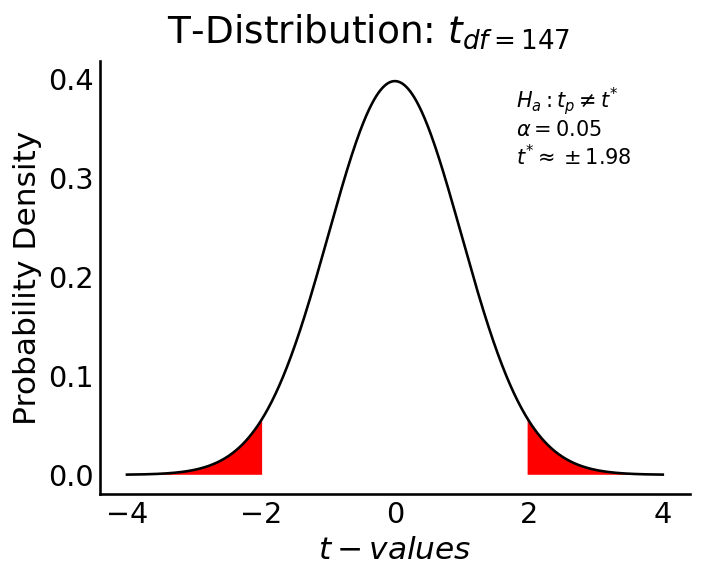

In [25]:
NeuroCluster.plotting_utils.plot_tcritical(cluster_test)

Now, we are reading to run our linear regression based on the dependent neural variable (`tfr_data`) and independent behavioral variables (`predictor_data`, `target_var`) we passed as inputs to our `TFR_Cluster_Test` object. This will return pixel-level **β coefficients** and corresponding **t-statistics** for our TFR data in one electrode.

In [26]:
betas, tstats = cluster_test.tfr_regression()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 32784 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    9.4s finished


Let's plot the **β coefficients** to give us an idea of the neural encoding pattern for our continuous predictor of interest.

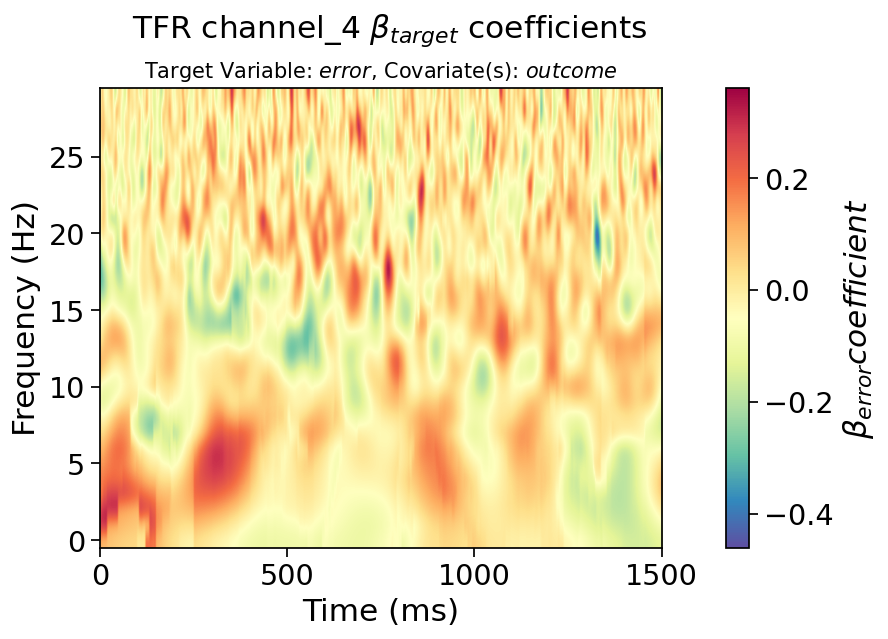

In [27]:
NeuroCluster.plot_beta_coef(betas,cluster_test)

We can also plot the **t-statistics** that correspond with the **β coefficient** for each time-frequency point.

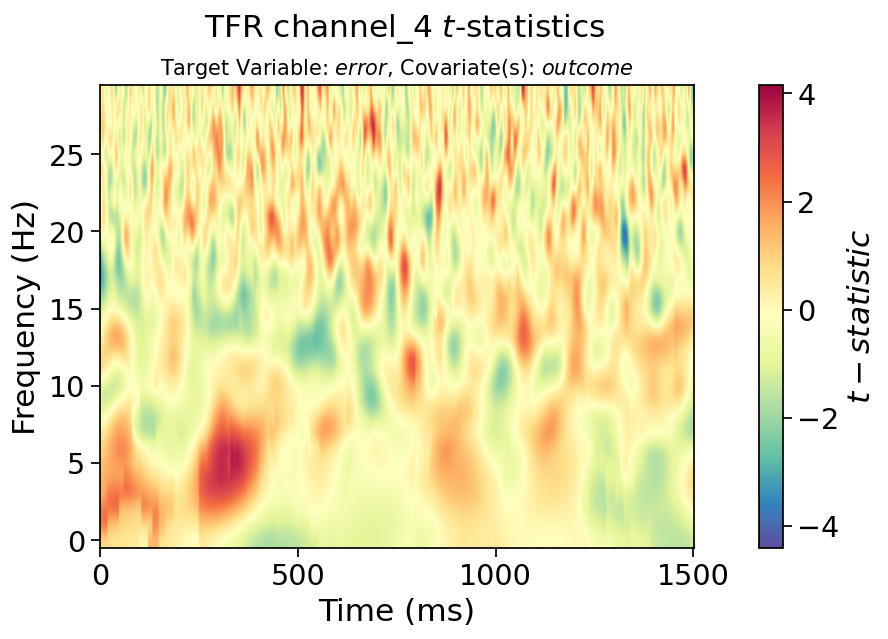

In [28]:
NeuroCluster.plot_tstats(tstats,cluster_test)

Let's highlight **clusters** (defined as consecutive time x frequency points) with significant t-statistics. We can do this separately for both positive and negative clusters. 

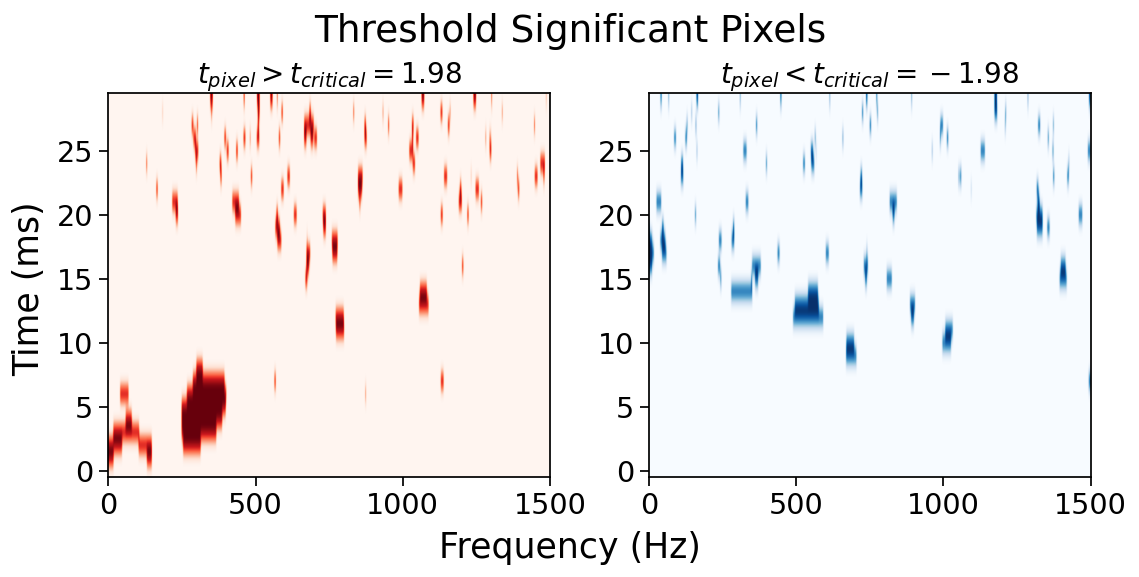

In [29]:
NeuroCluster.plot_clusters(tstats,cluster_test)

# Step 3: Calculate True Cluster Statistic(s) 

Now, we will identify the largest cluster (either/both positive and negative) and save the **cluster statistic** which will be our test statistic against our non-parametric null distribution. `max_tfr_cluster()` returns a dictionary containing the **cluster statistic**:`cluster_stat` and its associated **freq_idx**: `freq_idx` and **time_idx**:`time_idx`.

In [31]:
# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,max_cluster_output='all')
print(f'Max positive cluster dictionary: {max_cluster_data[0]}')
print(f'Max negative cluster dictionary: {max_cluster_data[1]}')

Max positive cluster dictionary: {'cluster_stat': 2108.9096700212563, 'freq_idx': (2, 8), 'time_idx': (250, 401)}
Max negative cluster dictionary: {'cluster_stat': -527.2224197852879, 'freq_idx': (12, 14), 'time_idx': (489, 591)}


Let's plot our largest cluster and its associated **cluster statistic**

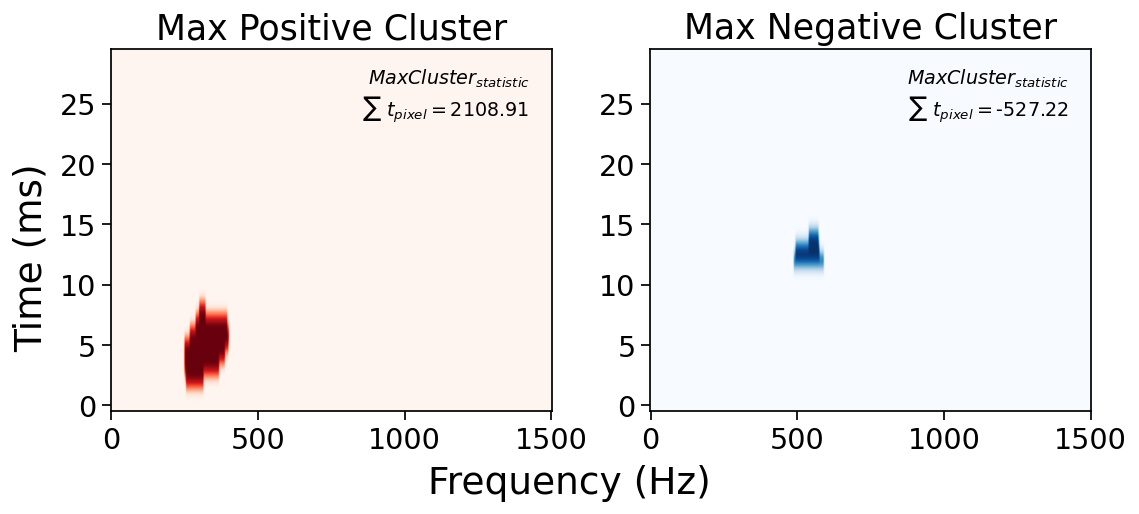

In [32]:
NeuroCluster.plot_max_clusters(cluster_test,tstats)

# Step 4: Compute cluster p-value(s) from null distribution of cluster statistics. 
To generate the null distribution, perform non-parametric cluster-based permutation testing by randomly permuting predictor of interest (target_var). 

At this point, we have computed the true cluster statistics from our neural (`tfr_data`) and behavioral data (`predictor_data`, `target_var`). Next, we will permute our input data and re-run the cluster identification procedure on each permuted dataset. This will allow us to generate a null distribution of cluster statistics, which we can use to evaluate the statistical significance of the cluster statistics observed in our true data.

`compute_null_cluster_stats()` takes `num_permutations` as an input, which specifies the desired number of permutations. The function will permute the regressor of interest according to this number. It returns a list of null cluster statistics, with the length of the list depending on the tails of the test. Here we generated 100 null cluster statistics, `num_permutations=100`, but we recommend running at least 200 permutations (500 to 1000 is best practice). 

In [33]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=100)

In [34]:
null_cluster_distribution

[[330.57867797906994,
  602.7468103035051,
  1976.0563207789626,
  851.923553503819,
  728.5837962902683,
  215.01421376423582,
  2270.65897009315,
  767.2939633930225,
  450.6826719762771,
  434.32990404374607,
  442.2037346631686,
  681.8632582061846,
  163.53341531786975,
  144.4373243227587,
  259.8034437428348,
  336.4156228984258,
  168.65069893982528,
  1579.781991417849,
  854.6795537172977,
  702.852925322627,
  1794.6049184631843,
  3349.3398496835352,
  324.0252828468758,
  4412.76467685659,
  1082.7992113458333,
  381.5420569490374,
  489.5967629366373,
  432.9845384931882,
  245.04292821088396,
  262.5323619121193,
  303.40559037014316,
  3331.0622147631284,
  315.48741070584686,
  848.7969043327826,
  806.239580839361,
  462.4391351421914,
  1283.848898208586,
  769.8045019542708,
  221.15152506916104,
  201.88012039695266,
  376.86329425822373,
  2327.7844338664013,
  589.6749757915369,
  708.2582907342412,
  2384.9788896803684,
  596.7679783513565,
  297.68901108529826,

We will compute the ***p*-value** associated with our true cluster statistics based on the null distributions we create using `cluster_significance_test()`.

In [35]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 
print(f'Positive cluster p-value: {cluster_pvalue[0]}')
print(f'Negative cluster p-value: {cluster_pvalue[1]}')

Positive cluster p-value: 0.09
Negative cluster p-value: 0.39


Let's create a plot showing the **null distribution(s)** we generated, with our true cluster statistic overlaid on top.

In [41]:
for i, cluster in enumerate(max_cluster_data):
    # extract null data based on type of hypothesis test 
    l_fn = lambda x,i: x if len(x)>2 else x[i]
    null_data = l_fn(null_cluster_distribution,i)
    print(i,cluster,null_data)

0 {'cluster_stat': 2108.9096700212563, 'freq_idx': (2, 8), 'time_idx': (250, 401)} [330.57867797906994, 602.7468103035051, 1976.0563207789626, 851.923553503819, 728.5837962902683, 215.01421376423582, 2270.65897009315, 767.2939633930225, 450.6826719762771, 434.32990404374607, 442.2037346631686, 681.8632582061846, 163.53341531786975, 144.4373243227587, 259.8034437428348, 336.4156228984258, 168.65069893982528, 1579.781991417849, 854.6795537172977, 702.852925322627, 1794.6049184631843, 3349.3398496835352, 324.0252828468758, 4412.76467685659, 1082.7992113458333, 381.5420569490374, 489.5967629366373, 432.9845384931882, 245.04292821088396, 262.5323619121193, 303.40559037014316, 3331.0622147631284, 315.48741070584686, 848.7969043327826, 806.239580839361, 462.4391351421914, 1283.848898208586, 769.8045019542708, 221.15152506916104, 201.88012039695266, 376.86329425822373, 2327.7844338664013, 589.6749757915369, 708.2582907342412, 2384.9788896803684, 596.7679783513565, 297.68901108529826, 451.23855

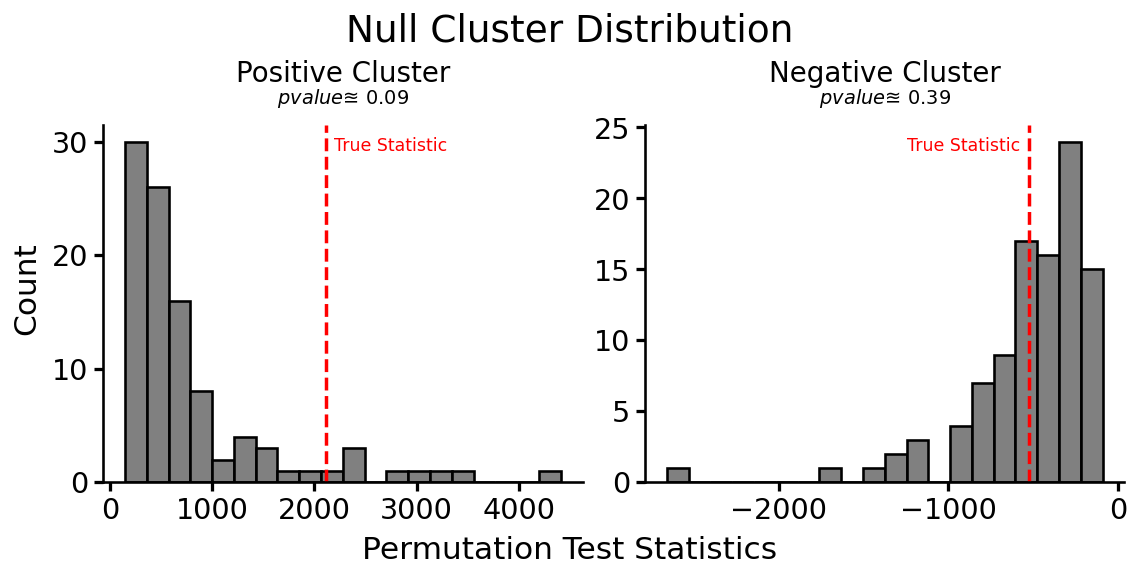

In [52]:
NeuroCluster.plot_null_distribution(null_cluster_distribution, max_cluster_data,cluster_pvalue,dpi=125)

In [55]:
# Save all plots
tstat_threshold = cluster_test.threshold_tfr_tstat(tstats)
tcrit_plot,beta_plot,tstat_plot,cluster_plot,max_cluster_plot,null_distribution_plot = NeuroCluster.plot_neurocluster_results(betas,cluster_test,
                                                                                                                    max_cluster_data, null_cluster_distribution, tstats, tstat_threshold,cluster_pvalue)

# Define the directory where you want to save the plots
output_directory = f'{results_dir}/{demo_channel}_{target_var}'

# Create the directory if it doesn't exist
NeuroCluster.create_directory(output_directory)

# Save plots to the output directory
NeuroCluster.save_plot_to_pdf(tcrit_plot, output_directory, f'{cluster_test.alternative}_tcrit_plot.pdf')
NeuroCluster.save_plot_to_pdf(beta_plot, output_directory, f'{cluster_test.alternative}_beta_plot.pdf')
NeuroCluster.save_plot_to_pdf(tstat_plot, output_directory, f'{cluster_test.alternative}_tstat_plot.pdf')
NeuroCluster.save_plot_to_pdf(cluster_plot, output_directory, f'{cluster_test.alternative}_cluster_plot.pdf')
NeuroCluster.save_plot_to_pdf(max_cluster_plot, output_directory, f'{cluster_test.alternative}_max_cluster_plot.pdf')
NeuroCluster.save_plot_to_pdf(null_distribution_plot, output_directory, f'{cluster_test.alternative}_null_distribution_plot.pdf')


### Let's run the entire pipeline at once and save plots. 

In [23]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = NeuroCluster.TFR_Cluster_Test(tfr_data,predictor_data,target_var,demo_channel,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR. Determine which t-statistics are significant based on the critical t-value and save a thresholded t-statistic matrix.
betas, tstats = cluster_test.tfr_regression()
tstat_threshold = cluster_test.threshold_tfr_tstat(tstats)

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,max_cluster_output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=100)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 

# Let's plot all the steps together and save the figures to a dictory that corresponds to the channel and predictor of interest. 
beta_plot,tstat_plot,cluster_plot,max_cluster_plot,null_distribution_plot = NeuroCluster.plot_neurocluster_results(betas,cluster_test, max_cluster_data, null_cluster_distribution, tstats, tstat_threshold,cluster_pvalue)

# Define the directory where you want to save the plots
output_directory = f'{results_dir}/{demo_channel}_{target_var}'

# Create the directory if it doesn't exist
NeuroCluster.create_directory(output_directory)

# Save plots to the output directory
NeuroCluster.save_plot_to_pdf(beta_plot, output_directory, 'beta_plot.png')
NeuroCluster.save_plot_to_pdf(tstat_plot, output_directory, 'tstat_plot.png')
NeuroCluster.save_plot_to_pdf(cluster_plot, output_directory, 'cluster_plot.png')
NeuroCluster.save_plot_to_pdf(max_cluster_plot, output_directory, 'max_cluster_plot.png')
NeuroCluster.save_plot_to_pdf(null_distribution_plot, output_directory, 'null_distribution_plot.png')

# One-Sided Hypothesis Test Example
Rather than testing whether a tfr cluster significantly encodes our `target_var` in general, we can evaluate the directionality of `target_var` encoding in our cluster. Specifically, we can test whether neuronal activity in a cluster increases (or decreases) with increasing (or decreasing) values of the `target_var`.

In [284]:
cluster_test  = NeuroCluster.TFR_Cluster_Test(tfr_data,predictor_data,target_var,demo_channel,alternative='greater')
cluster_test

To calculate t-critical for a one-sided hypothesis test, we compute a T-distribution with N-K-1 degrees of freedom (N=number of samples, K = number of predictors in regression model) and find the t-value where the area of the t-distribution = 0.95 (1-alpha,alpha=0.05). 


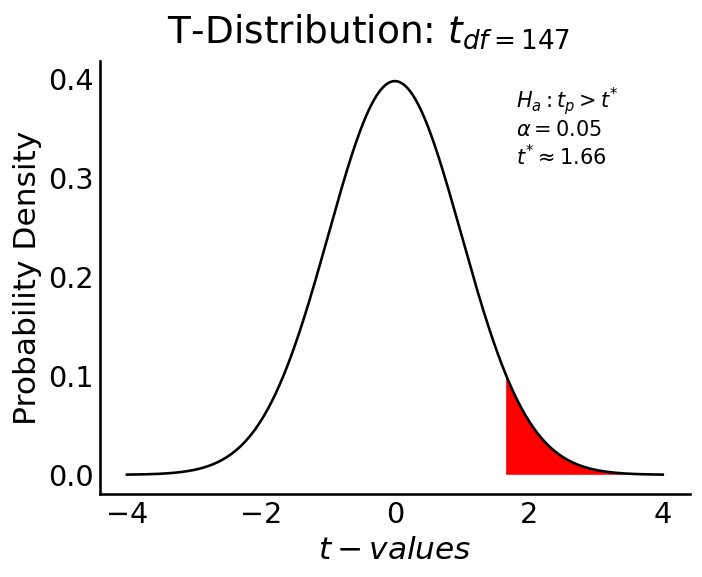

In [268]:
NeuroCluster.plotting_utils.plot_tcritical(cluster_test)

Now, we are reading to run our linear regression based on the dependent neural variable (`tfr_data`) and independent behavioral variables (`predictor_data`, `target_var`) we passed as inputs to our `TFR_Cluster_Test` object. This will return pixel-level **β coefficients** and corresponding **t-statistics** for our TFR data in one electrode.

In [269]:
betas, tstats = cluster_test.tfr_regression()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 32784 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:   10.2s finished


Let's plot the **β coefficients** to give us an idea of the neural encoding pattern for our continuous predictor of interest.

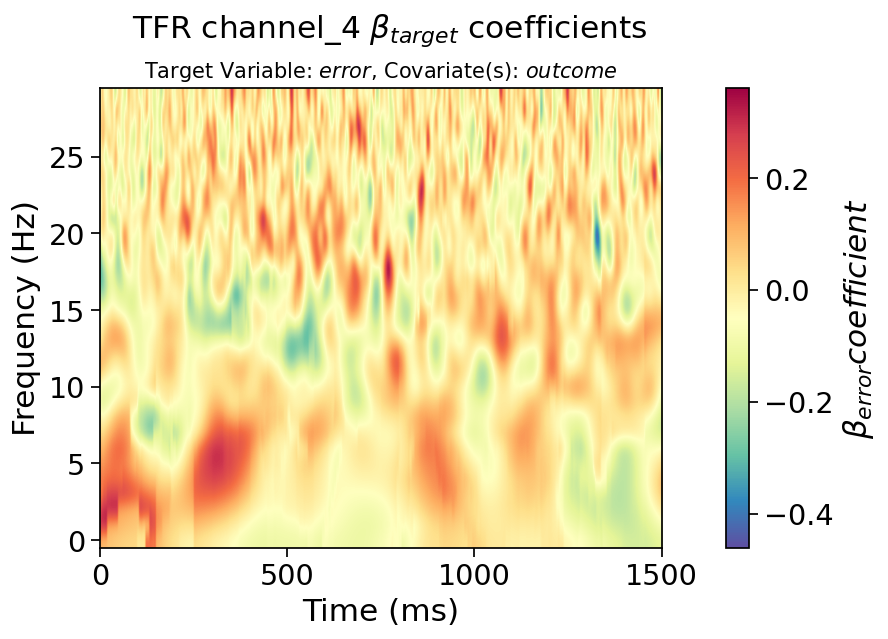

In [273]:
NeuroCluster.plot_beta_coef(betas,cluster_test)

We can also plot the **t-statistics** that correspond with the **β coefficient** for each time-frequency point.

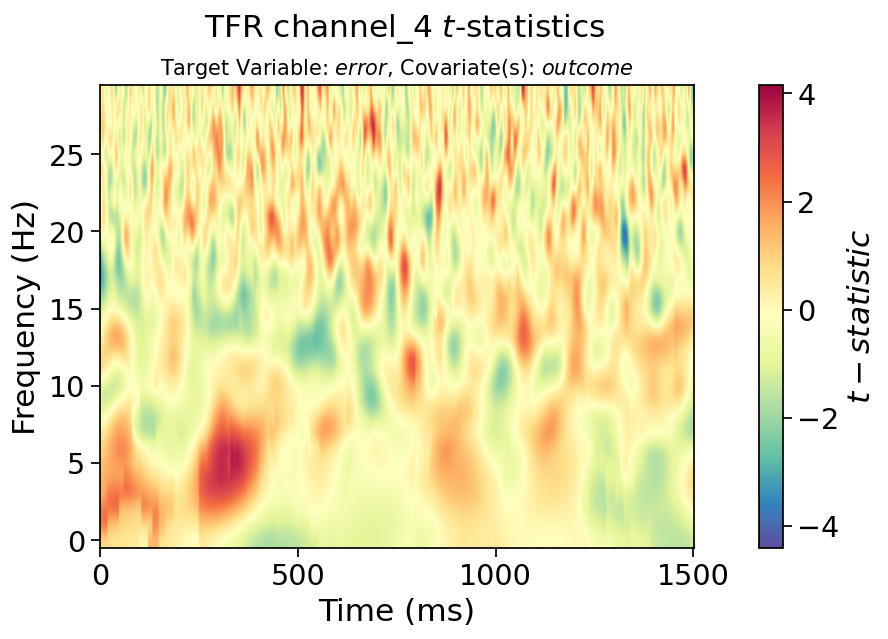

In [274]:
NeuroCluster.plot_tstats(tstats,cluster_test)

Let's highlight **clusters** (defined as consecutive time x frequency points) with significant t-statistics.

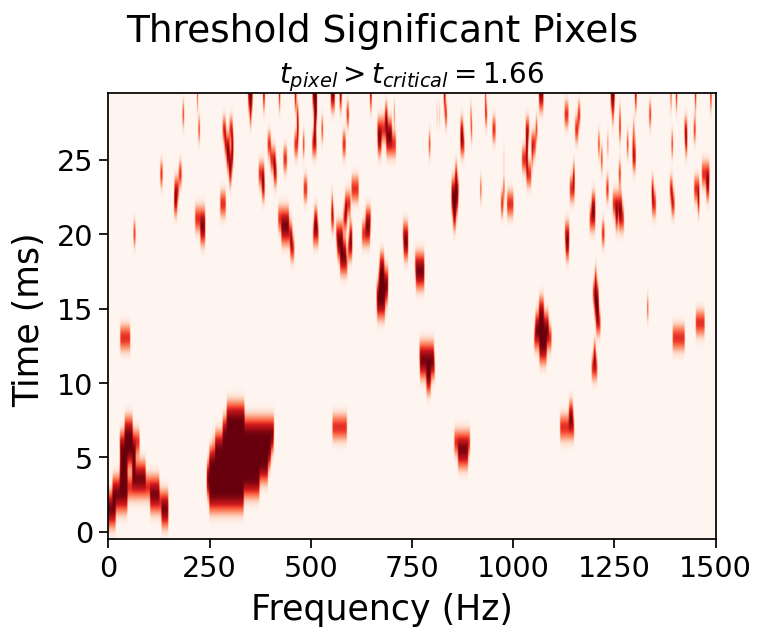

In [275]:
NeuroCluster.plot_clusters(tstats,cluster_test,figsize=(6,5))

# Step 3: Calculate True Cluster Statistic(s) 

Now, we will identify the largest cluster (either/both positive and negative) and save the **cluster statistic** which will be our test statistic against our non-parametric null distribution. `max_tfr_cluster()` returns a dictionary containing the **cluster statistic**:`cluster_stat` and its associated **freq_idx**: `freq_idx` and **time_idx**:`time_idx`.

In [276]:
# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,max_cluster_output='all')
print(f'Max positive cluster dictionary: {max_cluster_data[0]}')

Max positive cluster dictionary: {'cluster_stat': 2300.5671671842847, 'freq_idx': (2, 8), 'time_idx': (244, 409)}


Let's plot our **positive** largest cluster and its associated **cluster statistic**

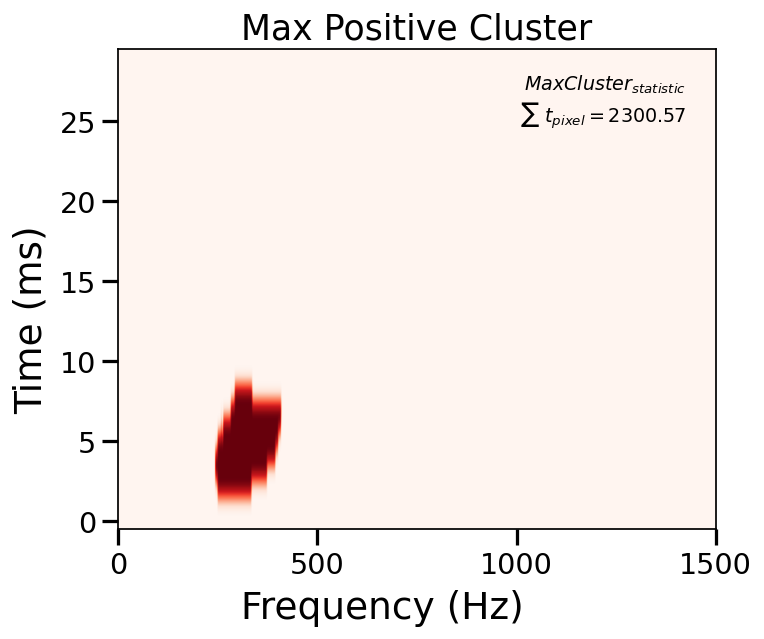

In [277]:
NeuroCluster.plot_max_clusters(cluster_test,tstats,figsize=(6,5))

# Step 4: Compute cluster p-value(s) from null distribution of cluster statistics. 
To generate the null distribution, perform non-parametric cluster-based permutation testing by randomly permuting predictor of interest (target_var). 

At this point, we have computed the true cluster statistics from our neural (`tfr_data`) and behavioral data (`predictor_data`, `target_var`). Next, we will permute our input data and re-run the cluster identification procedure on each permuted dataset. This will allow us to generate a null distribution of cluster statistics, which we can use to evaluate the statistical significance of the cluster statistics observed in our true data.

`compute_null_cluster_stats()` takes `num_permutations` as an input, which specifies the desired number of permutations. The function will permute the regressor of interest according to this number. It returns a list of null cluster statistics, with the length of the list depending on the tails of the test. Here we generated 100 null cluster statistics, `num_permutations=100`, but we recommend running at least 200 permutations (500 to 1000 is best practice). 

In [278]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=100)

In [279]:
null_cluster_distribution

[520.5686858575938,
 219.10190599529847,
 402.72977346710366,
 2929.4566471159555,
 484.3155519224895,
 2926.4716045645155,
 470.7884699395561,
 896.0614351871001,
 422.7940908585674,
 669.6308197681465,
 1569.1818881678123,
 421.78009841163066,
 988.9841975334982,
 1257.1342047368043,
 330.87804424539434,
 1543.5308677477701,
 2237.5547020362474,
 501.47237515619355,
 573.0806584148938,
 204.3659962945587,
 2756.2000497260274,
 1033.453904528953,
 448.8325680748445,
 2695.472388913431,
 490.6720715638164,
 442.2095806721427,
 822.9059694616026,
 677.110252221874,
 836.4784163719872,
 746.6966402290493,
 1052.7519333094897,
 369.1031413978525,
 786.0800214326481,
 290.26456441009736,
 648.3211390459696,
 1282.278701834765,
 604.0960862370472,
 1087.5510327244942,
 5159.4929070519465,
 266.55702465689757,
 1132.274727679099,
 512.0235874502854,
 310.8113464175258,
 713.5407816903173,
 1006.2449286240526,
 2216.446881526032,
 582.333985357662,
 2606.08340792701,
 750.6464259840873,
 598.

We will compute the ***p*-value** associated with our true cluster statistics based on the null distributions we create using `cluster_significance_test()`.

In [280]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 
print(f'Positive cluster p-value: {cluster_pvalue[0]}')

Positive cluster p-value: 0.12


Let's create a plot showing the **null distribution(s)** we generated, with our true cluster statistic overlaid on top.

In [281]:
null_cluster_distribution

[520.5686858575938,
 219.10190599529847,
 402.72977346710366,
 2929.4566471159555,
 484.3155519224895,
 2926.4716045645155,
 470.7884699395561,
 896.0614351871001,
 422.7940908585674,
 669.6308197681465,
 1569.1818881678123,
 421.78009841163066,
 988.9841975334982,
 1257.1342047368043,
 330.87804424539434,
 1543.5308677477701,
 2237.5547020362474,
 501.47237515619355,
 573.0806584148938,
 204.3659962945587,
 2756.2000497260274,
 1033.453904528953,
 448.8325680748445,
 2695.472388913431,
 490.6720715638164,
 442.2095806721427,
 822.9059694616026,
 677.110252221874,
 836.4784163719872,
 746.6966402290493,
 1052.7519333094897,
 369.1031413978525,
 786.0800214326481,
 290.26456441009736,
 648.3211390459696,
 1282.278701834765,
 604.0960862370472,
 1087.5510327244942,
 5159.4929070519465,
 266.55702465689757,
 1132.274727679099,
 512.0235874502854,
 310.8113464175258,
 713.5407816903173,
 1006.2449286240526,
 2216.446881526032,
 582.333985357662,
 2606.08340792701,
 750.6464259840873,
 598.

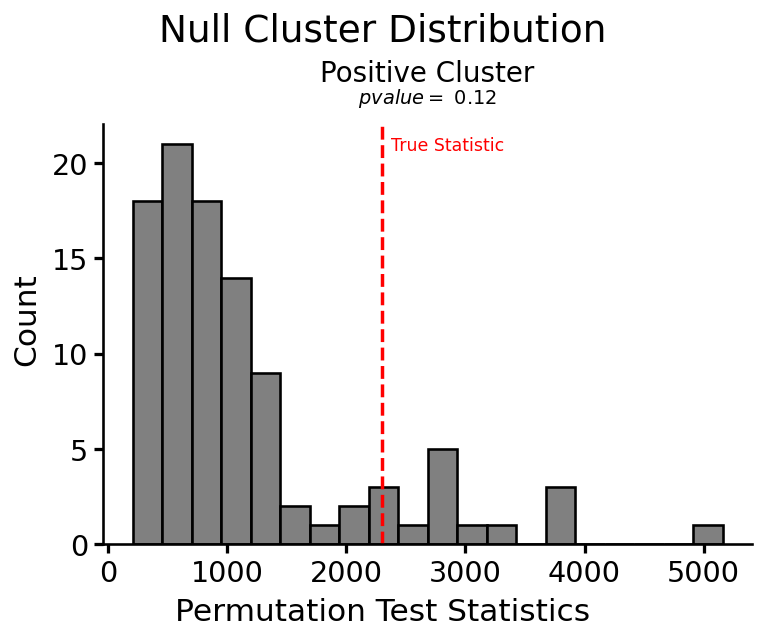

In [285]:
NeuroCluster.plot_null_distribution(null_cluster_distribution, max_cluster_data,cluster_pvalue,figsize=(6,5),dpi=125)